## 튜토리얼

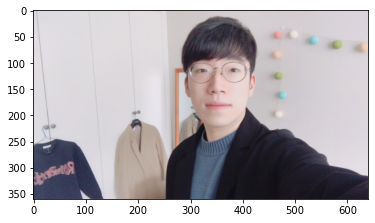

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img = cv2.cvtColor(cv2.resize(cv2.imread(my_image_path), (640, 360)) , cv2.COLOR_BGR2RGB)
img_show = img.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img)
plt.show()

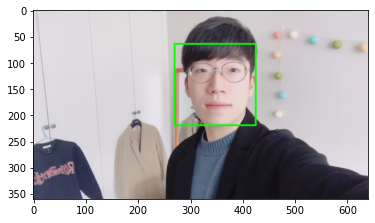

In [2]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img, 1)   #- (image, num of img pyramid)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)


plt.imshow(img_show)
plt.show()


In [3]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [4]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img.copy(), dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


68


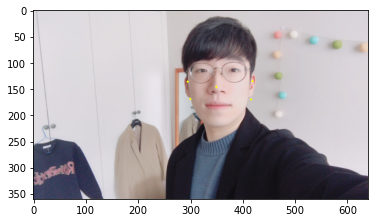

In [5]:
img_show = img.copy()
want_point = [1,30,15,3,13]
for landmark in list_landmarks:
    for i in want_point:
        point = list_points[i]
    #for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (255, 255, 0), -1) # yellow

plt.imshow(img_show)
plt.show()


In [6]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))


(350, 146)
(x,y) : (350,68)
(w,h) : (156,156)


(156, 156, 3)
(x,y) : (272,-88)


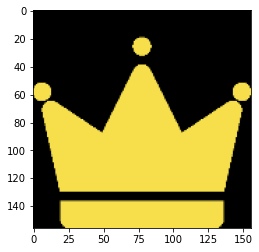

In [7]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker =  cv2.cvtColor(cv2.resize(cv2.imread(sticker_path), (w,h)), cv2.COLOR_BGR2RGB)
print (img_sticker.shape)

refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

plt.imshow(img_sticker)
plt.show()

(68, 156, 3)
(x,y) : (272,0)


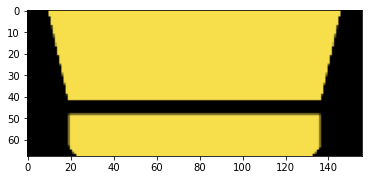

In [8]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))


plt.imshow(img_sticker)
plt.show()

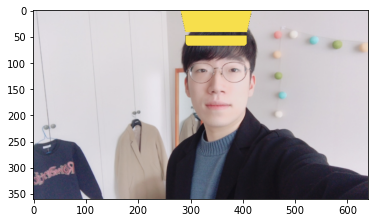

In [9]:
img_show = img.copy()
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
   np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(img_show)
plt.show()

# 고양이 스티커 전처리

##### 적용하려는 이미지의 해당 픽셀이 0값이다. 따라서 png로 불러오면 검은 화면만 볼 수 있다. 따라서 png가 아닌 jpg형태를 불러온다.

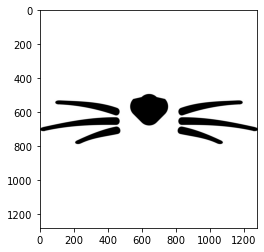

In [10]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_marker.jpg'
img_sticker =  cv2.cvtColor(cv2.imread(sticker_path), cv2.COLOR_BGR2RGB)

plt.imshow(img_sticker)
plt.show()

###### 해당 영역에서 쓰지 않는 부분이 너무 많다 이 부분을 덜어낸다.

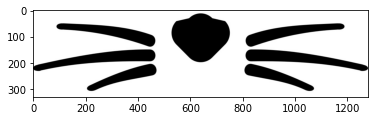

In [11]:
img_sticker = img_sticker[480:810]
plt.imshow(img_sticker)
plt.show()

## test

###### 여기서는 얼굴의 각도에 따라 다르게 적용하고자 한다. 고양이 코의 중앙은 사람의 얼굴, 왼쪽상단은 1번 점, 오른쪽 상단은 15, 왼쪽 하단은 3, 오른쪽 하단은 13 점으로 두고 호모그래피 변환을 이용할 것이다. 적용시에는 스티커 이미지의 픽셀이 0인 부분을 원본 이미지에서 0으로 만든다.

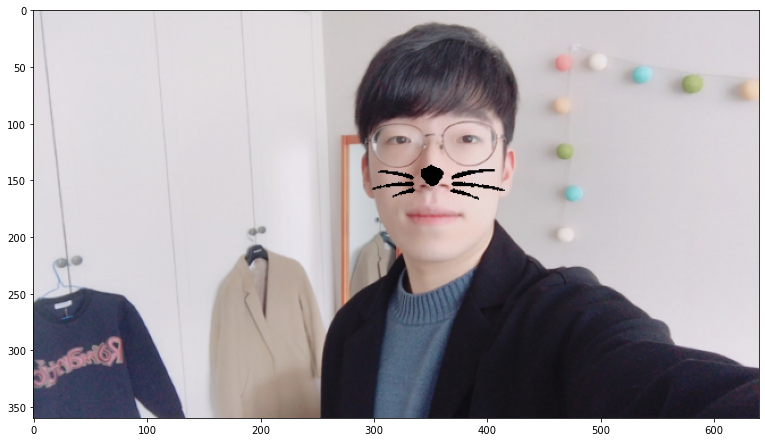

In [12]:
img_sticker = cv2.resize(img_sticker,(img.shape[0],img.shape[1]))
H,W,C = img_sticker.shape

stick_pos = np.array([[W//2,H//3],[0,0],[W,0],[0,H],[W,H]])
img_pos = np.array([landmark[30],landmark[1],landmark[15],landmark[3],landmark[13]])

# 각도에 맞춰 적용하기 위해 호모그래피 변환을 사용하였다.
h, status = cv2.findHomography(stick_pos,img_pos) 
img_sticker = cv2.warpPerspective(img_sticker,h,(H,W),cv2.INTER_AREA,borderValue=(255, 255, 255))

plt.figure(figsize=(13,13))
img_show = img.copy()
img_show = np.where(img_sticker==0,0,img_show)
plt.imshow(img_show)
plt.show()

## 적용하기

### 감지 안되는 각도

In [13]:
def detect(img,detector):
    dlib_rects = detector(img, 1)
    ret = img.copy()
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img.copy(), dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        for idx, point in enumerate(list_points):
            cv2.circle(ret, point, 2, (255, 255, 0), -1)
    return ret
    

In [14]:
import cv2
import matplotlib.pyplot as plt

video_capture = cv2.VideoCapture(0)

captured_img = []

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_marker.jpg'
cat_sticker =  cv2.cvtColor(cv2.imread(sticker_path), cv2.COLOR_BGR2RGB)
cat_sticker = cat_sticker[480:810]
detector_hog = dlib.get_frontal_face_detector()

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    # Display the resulting frame
    frame = detect(frame,detector_hog)
    cv2.imshow('Video', frame)
    
    key = cv2.waitKey(1)
    if  key == ord('q'):
        break
    
    if  key == ord('c'):
        captured_img.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

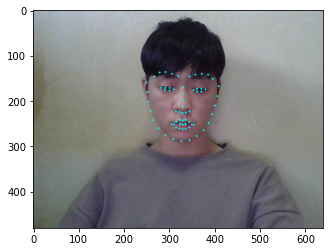

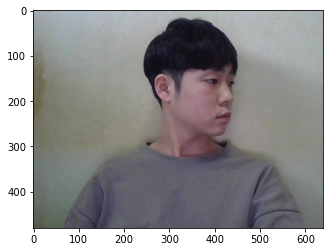

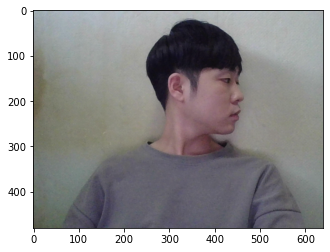

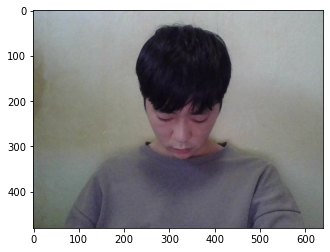

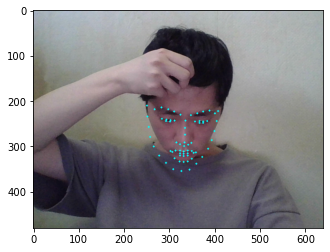

In [15]:
for f in captured_img:
    plt.imshow(f)
    plt.show()

#### 포인트중에 어느정도 감지하지 못하면 전체적으로 감지가 안되는 것 같다. 고개를 아래로 했을 때 턱이 가려지지 않았음에도 감지를 못하는 경우에 눈썹이 드러나면 감지가 되기도 한다.

### 얼굴에 고양이 마커 적용하기

In [16]:
def detect_face(img,detector,sticker):
    dlib_rects = detector(img, 1)
    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img.copy(), dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    
    mask = cv2.resize(sticker,(img.shape[0],img.shape[1]))
    H,W,C = mask.shape
    
    ret = img.copy()
    for landmark in list_landmarks:
        stick_pos = np.array([[W//2,H//3],[0,0],[W,0],[0,H],[W,H]])
        img_pos = np.array([landmark[30],landmark[1],landmark[15],landmark[3],landmark[13]])
        h, status = cv2.findHomography(stick_pos,img_pos)
        mask = cv2.warpPerspective(mask,h,(H,W),cv2.INTER_AREA,borderValue=(255, 255, 255))
        ret = np.where(mask==0,0,ret)

    return ret


In [17]:
import cv2
import matplotlib.pyplot as plt

video_capture = cv2.VideoCapture(0)

captured_img = []

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_marker.jpg'
cat_sticker =  cv2.cvtColor(cv2.imread(sticker_path), cv2.COLOR_BGR2RGB)
cat_sticker = cat_sticker[480:810]
detector_hog = dlib.get_frontal_face_detector()

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Display the resulting frame
    frame = detect_face(frame,detector_hog,cat_sticker)
    cv2.imshow('Video', frame)
    
    key = cv2.waitKey(1)
    if  key == ord('q'):
        break
    
    if  key == ord('c'):
        captured_img.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

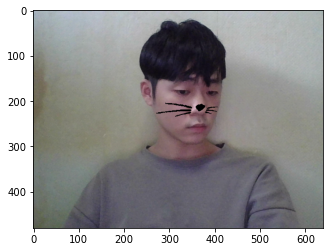

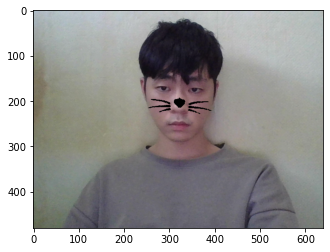

In [18]:
for f in captured_img:
    plt.imshow(f)
    plt.show()

#### 스티커 사진은 의도한대로 각도에 맞춰 변환되어 적용되었다.